## データの読込

In [1]:
import pandas as pd
df = pd.read_csv("vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


## クロスバリデーション

In [2]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from natsort import natsorted 

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.simplefilter('ignore')

In [3]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

### cross_validate

In [5]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

In [6]:
# 学習、推論

params = {
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }


model = lgb.LGBMRegressor(
                  **params,                    # ハイパーパラメータをセット
                  ) 

cv_results = cross_validate(
                            estimator = model,
                            X = X_train_ce, 
                            y = y_train,
                            scoring="neg_root_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True,
                            cv=5
                            )

print(cv_results["test_score"]*-1)
print(cv_results["test_score"].mean()*-1)

[0.19263034 0.21772842 0.2271128  0.19929657 0.19227929]
0.20580948396620186


In [7]:
cv_results

{'fit_time': array([0.17913008, 0.16000032, 0.18999887, 0.16722107, 0.17129159]),
 'score_time': array([0.0139966 , 0.00699997, 0.00799918, 0.00700116, 0.00999761]),
 'estimator': [LGBMRegressor(objective='regression', seed=42),
  LGBMRegressor(objective='regression', seed=42),
  LGBMRegressor(objective='regression', seed=42),
  LGBMRegressor(objective='regression', seed=42),
  LGBMRegressor(objective='regression', seed=42)],
 'test_score': array([-0.19263034, -0.21772842, -0.2271128 , -0.19929657, -0.19227929]),
 'train_score': array([-0.15433462, -0.14160424, -0.13786747, -0.15080765, -0.15196936])}

## KFold

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2280
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 20
[LightGBM] [Info] Start training from score 0.367371
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	Train's rmse: 0.194444	Test's rmse: 0.163985


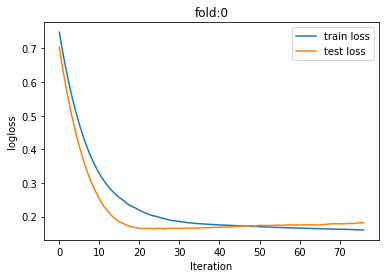

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 20
[LightGBM] [Info] Start training from score 0.364388
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	Train's rmse: 0.159282	Test's rmse: 0.212026


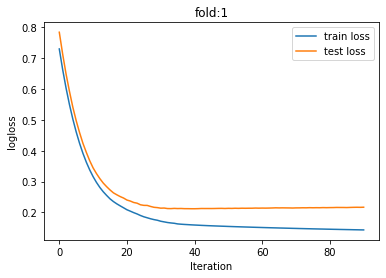

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 20
[LightGBM] [Info] Start training from score 0.366969
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137867	Test's rmse: 0.227113


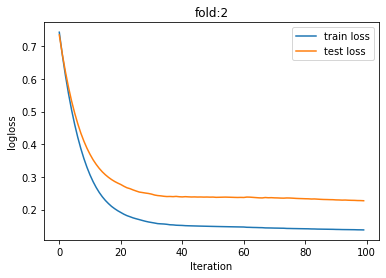

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 20
[LightGBM] [Info] Start training from score 0.364560
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150808	Test's rmse: 0.199297


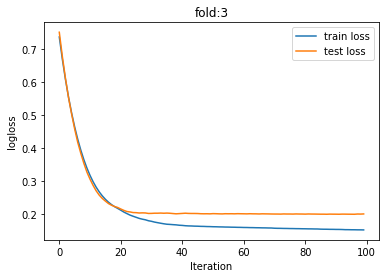

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2291
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 20
[LightGBM] [Info] Start training from score 0.369128
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151969	Test's rmse: 0.192279


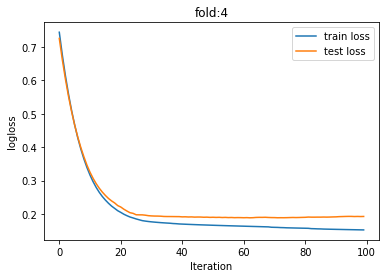

RMSE: [0.16398461099992923, 0.21202615379568318, 0.22711279960179856, 0.19929656830878598, 0.19227928747934217]
RMSE: 0.19893988403710783


In [8]:
kf = KFold(n_splits=5)

y_train = y_train.reset_index(drop=True)

params = {
          'task': 'train',                     # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},              # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

cv_result_kf = []

for fold , (train_index, test_index) in enumerate(kf.split(X_train_ce)):
    X_train_kf, X_test_kf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_kf, y_test_kf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_kf, y_train_kf)
    lgb_test = lgb.Dataset(X_test_kf, y_test_kf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.train(
                    params=params,                    # ハイパーパラメータをセット
                    train_set=lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                           # ログを最後の1つだけ表示
                    )  

    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_kf)

    # 評価
    rmse = mean_squared_error(y_test_kf, y_pred, squared=False)
    cv_result_kf.append(rmse)

print("RMSE:", cv_result_kf)
print("RMSE:", np.mean(cv_result_kf))

## GroupKFold

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	Train's rmse: 0.145024	Test's rmse: 0.345074


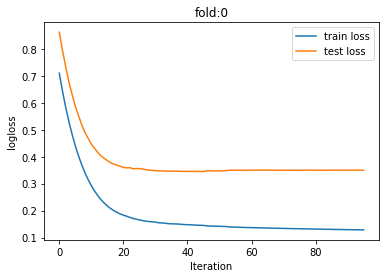

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148628	Test's rmse: 0.111997


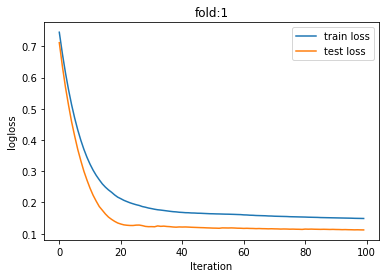

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146988	Test's rmse: 0.141503


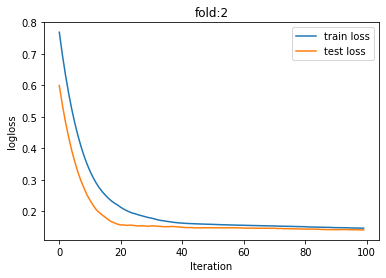

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	Train's rmse: 0.165773	Test's rmse: 0.0217725


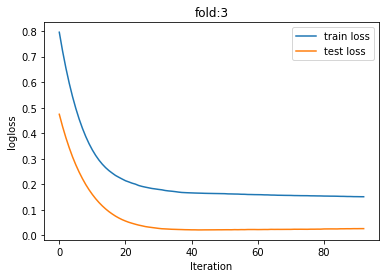

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	Train's rmse: 0.15906	Test's rmse: 0.373033


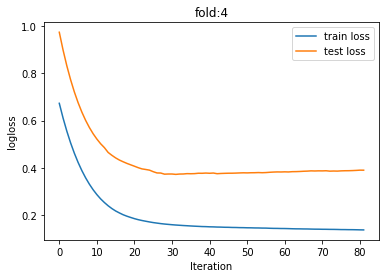

RMSE: [0.3450743092184951, 0.1119966357028154, 0.141502625741997, 0.021772539884382606, 0.37303280298429786]
RMSE: 0.1986757827063976


In [9]:
y_train = y_train.reset_index(drop=True)

gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',                      # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},              # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

cv_result_gkf = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.train(
                    params=params,                    # ハイパーパラメータをセット
                    train_set=lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                           # ログを最後の1つだけ表示
                    ) 
    
    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.title(f"fold:{fold}")
    plt.xlabel('Iteration')
    plt.ylabel('logloss')
    
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_gkf.append(rmse)

print("RMSE:", cv_result_gkf)
print("RMSE:", np.mean(cv_result_gkf))

## TimeSeriesSplit

In [10]:
# Yearで並び替え、ただしYearの欠損値は削除

X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Year"], how='any', axis=0).sort_values("Year").dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Year"], how='any', axis=0).sort_values("Year").dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=False, 
                                                    random_state=SEED
                                                    ) 

In [11]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1813
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 16
[LightGBM] [Info] Start training from score 0.472903
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	Train's rmse: 0.104381	Test's rmse: 0.31757


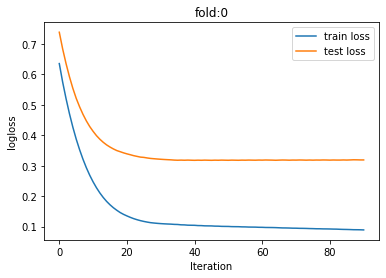

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1904
[LightGBM] [Info] Number of data points in the train set: 4523, number of used features: 17
[LightGBM] [Info] Start training from score 0.437588
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	Train's rmse: 0.196275	Test's rmse: 0.0920819


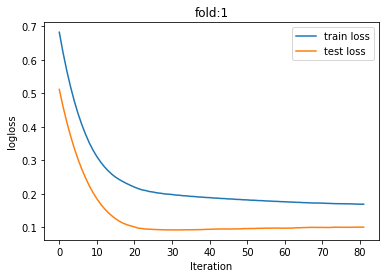

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1967
[LightGBM] [Info] Number of data points in the train set: 6783, number of used features: 18
[LightGBM] [Info] Start training from score 0.397312
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132229	Test's rmse: 0.0888447


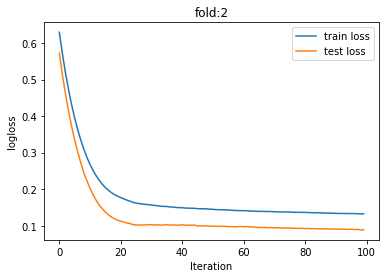

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2020
[LightGBM] [Info] Number of data points in the train set: 9043, number of used features: 18
[LightGBM] [Info] Start training from score 0.376512
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1122	Test's rmse: 0.102818


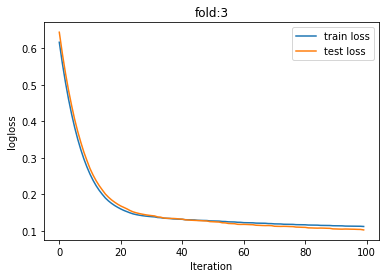

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2072
[LightGBM] [Info] Number of data points in the train set: 11303, number of used features: 18
[LightGBM] [Info] Start training from score 0.366514
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	Train's rmse: 0.116614	Test's rmse: 0.359854


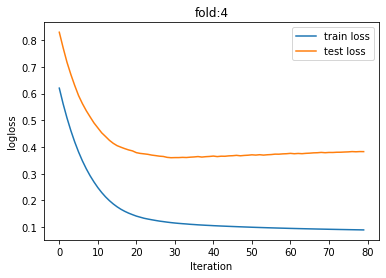

RMSE: [0.31756989358571397, 0.09208190098818901, 0.08884465409780268, 0.10281805025349675, 0.35985409955823405]
RMSE: 0.1922337196966873


In [12]:
y_train = y_train.reset_index(drop=True)

tscv = TimeSeriesSplit()

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},              # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

cv_result_tscv = []

for fold, (train_index, test_index) in enumerate(tscv.split(X_train_ce)):
    X_train_tscv, X_test_tscv = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_tscv, y_test_tscv = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_tscv, y_train_tscv)
    lgb_test = lgb.Dataset(X_test_tscv, y_test_tscv, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.train(
                    params=params,                    # ハイパーパラメータをセット
                    train_set=lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                           # ログを最後の1つだけ表示
                    )
    
    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')
    
    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_tscv)

    # 評価
    rmse = mean_squared_error(y_test_tscv, y_pred, squared=False)
    cv_result_tscv.append(rmse)

print("RMSE:", cv_result_tscv)
print("RMSE:", np.mean(cv_result_tscv))

## 改良 TimeSeriesSplit

In [13]:
# Yearで並び替え、ただしYearの欠損値は削除

X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Year"], how='any', axis=0).sort_values("Year").dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Year"], how='any', axis=0).sort_values("Year").dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=False, 
                                                    random_state=SEED
                                                    ) 

In [14]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

cv_result_tscv_impr = []

[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 36, number of used features: 0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.645278
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirem

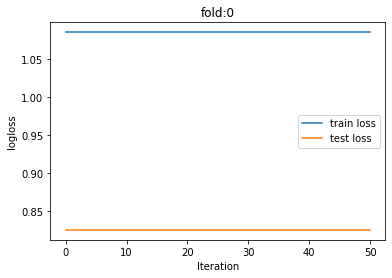

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.688158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

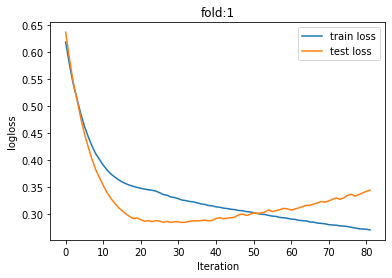

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 271, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.630886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

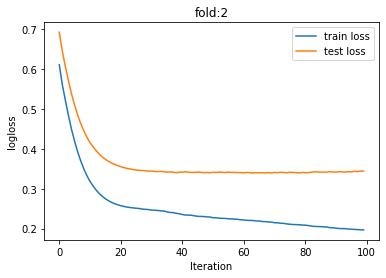

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1794
[LightGBM] [Info] Number of data points in the train set: 1766, number of used features: 16
[LightGBM] [Info] Start training from score 0.488007
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	Train's rmse: 0.116687	Test's rmse: 0.237236


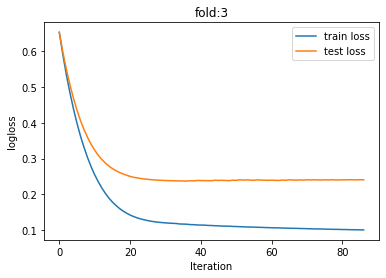

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1950
[LightGBM] [Info] Number of data points in the train set: 6214, number of used features: 18
[LightGBM] [Info] Start training from score 0.413359
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130773	Test's rmse: 0.206917


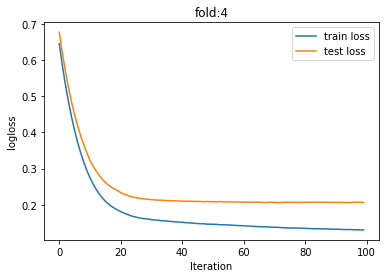

RMSE: [0.5809955052940895, 0.2841036898464653, 0.34419612861956717, 0.23723567218855932, 0.20691705931376334]
RMSE: 0.3306896110524889


In [15]:
tscv = TimeSeriesSplit()

for fold, (train_index, test_index) in enumerate(tscv.split(natsorted(X_train["Year"].dropna(how="any").unique()))):
    train_year = np.array(natsorted(X_train["Year"].dropna(how="any").unique()))[train_index]
    test_year = np.array(natsorted(X_train["Year"].dropna(how="any").unique()))[test_index]

    X_train_year = X_train[X_train["Year"].isin(train_year)]
    X_test_year = X_train[X_train["Year"].isin(test_year)]

    y_train_year = y_train[y_train.index.isin(X_train_year.index)]
    y_test_year = y_train[y_train.index.isin(X_test_year.index)]

    ### 欠損値補完
    X_train_ff = X_train_year.fillna(method='ffill')
    X_test_ff = X_test_year.fillna(method='ffill')

    #### カテゴリーエンコーディング

    # ユニーク数に応じてカラムを分割する
    category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

    few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
    many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


    # カテゴリーのエンコーディング法則を指定する
    ordinal_all_cols_mapping_ce = []

    for i, column in enumerate(many_kinds_category_columns):
        ordinal_one_cols_mapping = {}
        ordinal_one_cols_mapping_breakdown = {}
        for j, category in enumerate(natsorted(X_train_ff[column].unique())):
            ordinal_one_cols_mapping_breakdown[category] = j

        ordinal_one_cols_mapping["col"] = column
        ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
        ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


    # エンコーディング設定
    ode = ce.OrdinalEncoder(
        mapping = ordinal_all_cols_mapping_ce,
        cols = many_kinds_category_columns
    )

    ohe = ce.OneHotEncoder(
        use_cat_names=True,
        cols = few_kinds_category_columns
    )

    # 元データをコピー
    X_train_ce = X_train_ff.copy()
    X_test_ce = X_test_ff.copy()

    # OneHotEncoder
    X_train_ce = ohe.fit_transform(X_train_ce)
    X_test_ce = ohe.transform(X_test_ce)

    # OrdinalHotEncoder
    X_train_ce = ode.fit_transform(X_train_ce)
    X_test_ce = ode.transform(X_test_ce)

    # 正規化
    sc = StandardScaler()
    X_train_ce = pd.DataFrame(
                                sc.fit_transform(X_train_ce),
                                columns=X_train_ce.columns
                                )

    X_test_ce = pd.DataFrame(
                                sc.transform(X_test_ce),
                                columns=X_test_ce.columns
                                )
    
    # 学習、推論
    lgb_train = lgb.Dataset(X_train_ce, y_train_year)
    lgb_test = lgb.Dataset(X_test_ce, y_test_year, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.train(
                    params=params,                    # ハイパーパラメータをセット
                    train_set=lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                           # ログを最後の1つだけ表示
                    ) 
    
    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.title(f"fold:{fold}")
    plt.xlabel('Iteration')
    plt.ylabel('logloss')
    
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_ce)

    # 評価
    rmse = mean_squared_error(y_test_year, y_pred, squared=False)
    cv_result_tscv_impr.append(rmse)

print("RMSE:", cv_result_tscv_impr)
print("RMSE:", np.mean(cv_result_tscv_impr))

In [16]:
print("Cross Validation RMSE:", np.mean(cv_results["test_score"]))
print("KFold RMSE:", np.mean(cv_result_kf))
print("Group KFold RMSE:", np.mean(cv_result_gkf))
print("Time Split Validation RMSE:", np.mean(cv_result_tscv))
print("Time Split Validation 改良 RMSE:", np.mean(cv_result_tscv_impr))

Cross Validation RMSE: -0.20580948396620186
KFold RMSE: 0.19893988403710783
Group KFold RMSE: 0.1986757827063976
Time Split Validation RMSE: 0.1922337196966873
Time Split Validation 改良 RMSE: 0.3306896110524889
